<a href="https://colab.research.google.com/github/srilav/neuralnetwork/blob/main/M4_AST_05_Spectral_Clustering_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Assignment 5: Spectral Clustering

## Learning Objectives

At the end of the experiment, you will be able to

* understand what is graph clustering
* implement Spectral Clustering and KMeans Clustering algorithm

### Spectral Clustering

Spectral clustering is a popular unsupervised machine learning algorithm that often outperforms other approaches. In addition, spectral clustering is very simple to implement and can be solved efficiently by standard linear algebra methods. In spectral clustering, the affinity, and not the absolute location (i.e. k-means), determines what points fall under which cluster. The latter is particularly useful in tackling problems where the data forms complicated shapes.

**Algorithm**

The algorithm can be broken down into 4 basic steps.
1. Construct a similarity graph
2. Determine the Adjacency matrix W, Degree matrix D and the Laplacian matrix L
3. Compute the eigenvectors of the matrix L
4. Using the second smallest eigenvector as input, train a k-means model and use it to classify the data



The Scikit-learn API provides SpectralClustering class to implement spectral clustering method in Python. The SpectralClustering applies the clustering to a projection of the normalized Laplacian.

In this example, we'll briefly learn how to cluster and visualize data with SpectralClustering in Python. The example covers:

1. Preparing the data
2. Clustering with SpectralClustering and KMeans, for making comparison between the two algorithms.
3. Plot the results

### Setup Steps:

In [1]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "2200183" #@param {type:"string"}

In [3]:
#@title Please enter your password (your registered phone number) to continue: { run: "auto", display-mode: "form" }
password = "7671846954" #@param {type:"string"}

In [4]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()
  
notebook= "M4_AST_05_Spectral_Clustering_C" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")  
    ipython.magic("sx pip -qq install scprep graphtools louvain")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None
    
    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:        
        print(r["err"])
        return None   
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://cds.iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if not Additional: 
      raise NameError
    else:
      return Additional  
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None
  
  
# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None
  
def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None
  

def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError 
    else: 
      return Answer
  except NameError:
    print ("Please answer Question")
    return None
  

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup() 
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


### Import required packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans, SpectralClustering
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
# Scprep provides an all-in-one framework for loading, preprocessing, and plotting matrices in Python
import scprep              
import warnings
warnings.filterwarnings("ignore")

#### Preparing the data

Here, we are going to implement the SpectralClustering algorithm as well as the KMeans algorithm.

We'll be working with 2 datasets all in  $R^2$: 

1. Circles - two circles, one circumscribed by the other
2. Moons - Two interleaving half circles

Because we're generating these from scratch, we get to change some parameters of their distributions. Generally, we can change:

1. noise - the amount of Gaussian noise added to each point
2. n_samples - the number of points generated
3. factor / cluster_std - some parameters affecting shape
 

In [6]:
np.random.seed(0)

''' Generate datasets. We choose the size big enough to see the scalability
    of the algorithms, but not too big to avoid too long running times '''
  
n_samples = 1500

# Circles dataset
noisy_circles = sklearn.datasets.make_circles(
    n_samples=n_samples, 
    # Scale factor between inner and outer circle
    factor=.5,
    # Gaussian noise added to each point
    noise=.05)

# Moons dataset
noisy_moons = sklearn.datasets.make_moons(n_samples=n_samples, 
                                          noise=.05)

In [7]:
# Associate each dataset with the correct number of clusters
default_base = {'n_clusters': 3}

generated_datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2})
]

#### Plot ground truth cluster assignments

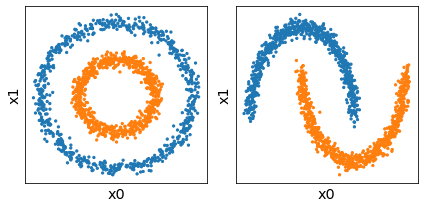

In [8]:
fig, axes = plt.subplots(1,2,figsize=(6,3))

for i, (dataset, _) in enumerate(generated_datasets):
    ax = axes[i]
    X, y = dataset
    
    # Normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    scprep.plot.scatter2d(X, c=y, 
                          ticks=None, ax=ax, 
                          xlabel='x0', ylabel='x1',
                         legend=False)
    
fig.tight_layout()

### Run clustering algorithms and plot results



It is an easy to understand data so we will cluster it with spectral cluster method.

We will define model by using SpectralClustering class and KMeans class and then we will fit it on x data. The SpectralClustering requires the number of clusters so we'll set `n_cluster`(define above) to n_cluster parameter. We can check the parameters of the class and change them according to your analysis and target data.

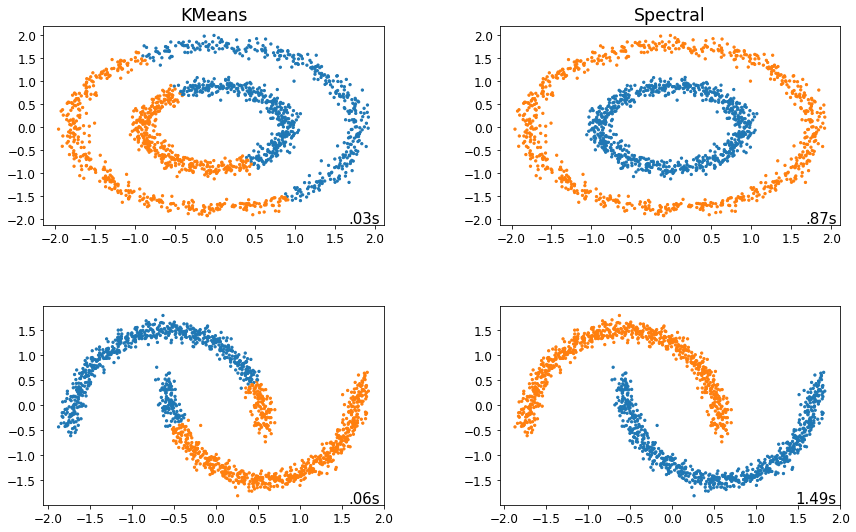

In [9]:
fig, axes = plt.subplots(2,2, figsize=(12, 7.5))
plot_title = True

for i_dataset, (dataset, cluster_params) in enumerate(generated_datasets):
    # update cluster parameters with dataset-specific values
    params = default_base.copy()
    params.update(cluster_params)

    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
  
    # Run clustering algorithms
    clusters = []
    titles = []
    times = []
    # KMeans
    tic = time.time()
    kmeans = KMeans(n_clusters=params['n_clusters'])
    clusters.append(kmeans.fit_predict(X))
    titles.append('KMeans')
    times.append(time.time() - tic)
    
    # Spectral Clustering
    tic = time.time()
    spectral = SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    clusters.append(spectral.fit_predict(X))
    titles.append('Spectral')
    times.append(time.time() - tic)

    # Plot clustering results for dataset
    row_axes = axes[i_dataset]
    
    for i, ax in enumerate(row_axes.flatten()):
        curr_cluster = clusters[i]
        if plot_title:
            curr_title = '{}'.format(titles[i])
        else:
            curr_title = None
            
        scprep.plot.scatter2d(X, c=curr_cluster, title=curr_title, ax=ax,
                             legend=False, discrete=True)

        # Plot time to run algorithm
        plt.text(.99, .01, ('%.2fs' % (times[i])).lstrip('0'),
                 transform=ax.transAxes, size=15,
                 horizontalalignment='right')
    plot_title=False
fig.tight_layout()

#### Discussion
In groups, change the following features for one or more of the distributions
1. `noise` - the amount of Gaussian noise added to each point
2. `n_samples` - the number of points generated
3. `factor` / `cluster_std` / `transformation` - some parameters affecting shape

Try to identify:
1. A set of parameters that makes `SpectralClustering` fail on the circles dataset
    - `factor=0.5, noise=0.1`

2. `KMeans` fail on the three regular blobs.
    - `cluster_std=4`

In this example, we have briefly learned how to cluster and visualize the data by using the `SpectralClustering` and `KMeans` algorithm in Python.

<font color='blue'>**Discussion 1:** Compare the Spectral Clustering and KMeans Clustering algorithms and discuss. Draw your conclusions.

Spectral clustering has many applications in real-life. Here are some of the few use cases of spectral clustering:

- **Spam filter:** You know the junk folder in your email inbox? It is the place where emails that have been identified as spam by the algorithm.
- **Marketing and Sales:** Personalization and targeting in marketing is big business. 
- **Classifying network traffic:** Imagine you want to understand the different types of traffic coming to your website. You are particularly interested in understanding which traffic is spam or coming from bots.
- **Document analysis:** There are many different reasons why you would want to run an analysis on a document. In this scenario, you want to be able to organize the documents quickly and efficiently.

### Theory Questions

1. What is an Adjacency Matrix in data science?

 In mathematics and computer science, an adjacency matrix is a means of representing which vertices of a graph are adjacent to which other vertices. Another matrix representation for a graph is the incidence matrix. Specifically, the adjacency matrix of a finite graph $G$ on $n$ vertices is the $n × n$ matrix where the non-diagonal entry $a_{ij}$ is the number of edges from vertex $i$ to vertex $j$, and the diagonal entry $a_{ii}$, depending on the convention, is either once or twice the number of edges (loops) from vertex $i$ to itself.

2. What are the 2 broad approaches for clustering?

 * **Compactness** — Points that lie close to each other fall in the same cluster and are compact around the cluster center. The closeness can be measured by the distance between the observations. E.g.: K-Means Clustering

 * **Connectivity** — Points that are connected or immediately next to each other are put in the same cluster. Even if the distance between 2 points is less, if they are not connected, they are not clustered together. Spectral clustering is a technique that follows this approach.

3. How does Spectral Clustering work?
 
 In spectral clustering, the data points are treated as nodes of a graph. Thus, clustering is treated as a graph partitioning problem. The nodes are then mapped to a low-dimensional space that can be easily segregated to form clusters. An important point to note is that no assumption is made about the shape/form of the clusters.

### Please answer the questions below to complete the experiment:




In [10]:
#@title Select the FALSE statement w.r.t. Spectral Clustering: { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "It assumes the variance of the distribution of each attribute (variable) is spherical" #@param ["", "The data points are treated as nodes of a graph", "The clustering is treated as a graph partitioning problem", "It assumes the variance of the distribution of each attribute (variable) is spherical"]

In [11]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [12]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "GOOD" #@param {type:"string"}


In [13]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [14]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [15]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [16]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 5733
Date of submission:  12 Dec 2021
Time of submission:  14:49:57
View your submissions: https://cds.iisc.talentsprint.com/notebook_submissions
